iter:50 training loss: 17.1728515625, val loss: 20.130859375
iter:100 training loss: 25.033203125, val loss: 18.009765625
iter:150 training loss: 3.433776617050171, val loss: 9.208465576171875
iter:200 training loss: 2.8052926063537598, val loss: 1.6948271989822388
iter:250 training loss: 2.384070634841919, val loss: 5.5604448318481445
iter:300 training loss: 1.840159296989441, val loss: 1.3177443742752075
iter:350 training loss: 6.44832181930542, val loss: 2.8796422481536865
iter:400 training loss: 1.7046830654144287, val loss: 3.0454885959625244
iter:450 training loss: 1.6127718687057495, val loss: 4.159500598907471
iter:500 training loss: 8.671034812927246, val loss: 5.488805770874023
iter:550 training loss: 1.6398993730545044, val loss: 5.231452465057373
iter:600 training loss: 2.121502161026001, val loss: 1.8644322156906128
iter:650 training loss: 1.695820927619934, val loss: 2.099560022354126
iter:700 training loss: 1.683272361755371, val loss: 1.8282644748687744
iter:750 trainin

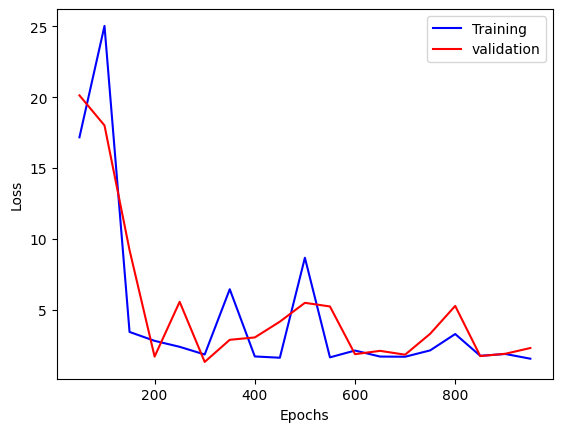

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import plotly.express as px
from dataclasses import dataclass

torch.manual_seed(10)



input_size =10
learning_rate = 0.003
max_iters = 1000
dataset_size = 1024
sparsity = 0.1
batch_size = 32

iters = []
loss_value = []
val_loss_value = []


def sample_data(split = 'train'):
    if split != 'train':
        curr_data = validation_dataset
    else:
        curr_data = training_dataset
    sparsity_vector = sparsity
    a, b = curr_data.shape
    
    sparsity_vector = torch.rand(input_size)
    sparsity_vector = sparsity_vector.view(1, -1)
    sparsity_mat = torch.bernoulli(torch.full((a, b), 1.0) * sparsity_vector)
    
    X = curr_data * sparsity_mat
    return X, X



DEVICE = torch.device('cpu')

@dataclass
class Config:
    input_size : int = 10
    hidden_size : int = 10
    layers : int = 10

class Two_Two(nn.Module):
    def __init__(self, hidden_size) -> None:
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(hidden_size,hidden_size), nn.ReLU(), nn.Linear(hidden_size,hidden_size) )
    
    def forward(self, idx):
        return self.layers(idx)

class Model(nn.Module):
    def __init__(self, config : Config) -> None:
        super().__init__()
        self.config = config
        self.layers = nn.Sequential(
                        nn.Linear(config.input_size, config.hidden_size),
                        *[Two_Two(config.hidden_size) for i in range(config.layers)],
                        nn.Linear(config.hidden_size, 1),
                        nn.ReLU()
                    )

    
    def forward(self, idx : torch.Tensor):
        count = self.layers(idx)
        loss = ((count-(idx>0).sum(-1))**2).mean()
        
        return count, loss


        

training_dataset = torch.rand(dataset_size, input_size)
validation_dataset = torch.rand(int(dataset_size/2), input_size)
output = input


model = Model(Config(input_size= input_size))


optimizer = torch.optim.Adam(model.parameters() , learning_rate, weight_decay= 1e-5)
start_time = time.time()
step_value = max_iters/20
for i in range(1, max_iters):
    X, Y = sample_data()
    count, loss = model(X)
   
    if i%step_value ==0 :
        model.eval()
        with torch.no_grad():
            X_V,Y_V = sample_data(split = 'val')
            _, val_loss= model(X_V)
            iters.append(i)
            loss_value.append(loss.item())
            val_loss_value.append(val_loss.item())
            print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
        model.train()

    optimizer.zero_grad(set_to_none=True)
    #loss+= get_l1_penalty()
    loss.backward()
    optimizer.step()


end_time = time.time()
print(f"Took {end_time-start_time}s for {max_iters} epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='blue', label="Training")
plt.plot(iters, val_loss_value, "red", label = "validation")
plt.legend()
plt.show()

In [50]:
a,b = sample_data()

In [51]:
a[:5]

tensor([[0.0000, 0.4829, 0.0000, 0.6150, 0.2139, 0.4118, 0.6938, 0.0000, 0.6178,
         0.3304],
        [0.0000, 0.0000, 0.0000, 0.5573, 0.6959, 0.9849, 0.0000, 0.0000, 0.6150,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0501, 0.0108, 0.0343, 0.0000, 0.0000, 0.0310,
         0.7192],
        [0.8067, 0.0000, 0.0000, 0.0000, 0.7203, 0.2235, 0.9502, 0.0000, 0.9314,
         0.6533],
        [0.0000, 0.0000, 0.0000, 0.3546, 0.5752, 0.4787, 0.5782, 0.0000, 0.1093,
         0.4771]])

In [52]:
model(a[:5])

(tensor([[4.8944],
         [4.8944],
         [4.8944],
         [4.8944],
         [4.8944]], grad_fn=<ReluBackward0>),
 tensor(1.5379, grad_fn=<MeanBackward0>))

In [53]:
(a[:5]>0).sum(-1)

tensor([7, 4, 5, 6, 6])